Question 1

In [ ]:
# Question 1

import numpy as np
from scipy.io import loadmat
data = loadmat('snp452-data.mat')

In [57]:
X = data['X']
stock_info = data['stock']

In [63]:
print(X.shape)
print(stock_info.shape)

(1258, 452)
(1, 452)


In [64]:
Y = np.log(X)

In [65]:
price_jumps = np.diff(Y, axis=1)


In [67]:
price_jumps.shape

(1258, 451)

In [68]:
cov_matrix = np.cov(price_jumps)

In [69]:
import pandas as pd

eigenvalues, eigenvectors = eigh(cov_matrix)

# Sort in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# make a dataframe
result_df = pd.DataFrame({
    'Eigenvalues': sorted_eigenvalues,
    'Eigenvectors': list(sorted_eigenvectors.T),
})

print(result_df.head()) # this displays first few rows

   Eigenvalues                                       Eigenvectors
0   694.088129  [-0.03038999146761359, -0.030309033130975216, ...
1   104.606713  [-0.04211784119134051, -0.04213677582158021, -...
2    21.384423  [-0.046751198471665714, -0.04783480195123477, ...
3    11.546673  [0.0031617107234427244, 0.0031205321154990735,...
4     8.880331  [-0.08527944465108396, -0.08554893663007064, -...


In [70]:
result_df.shape

(1258, 2)

In [98]:
from scipy.linalg import eigh

def horn(data_matrix, num_permutations):
    n, t = data_matrix.shape
    observed_covariance = np.cov(data_matrix)

    eigenvalues_observed, _ = eigh(observed_covariance)

    random_eigenvalues = []
    for _ in range(num_permutations):
        # random permutations
        permuted_data_matrix = data_matrix[:, np.random.permutation(t)]

        # Compute covariance matrix
        permuted_covariance = np.cov(permuted_data_matrix)
        eigenvalues_permuted, _ = eigh(permuted_covariance)

        random_eigenvalues.append(eigenvalues_permuted)

    random_eigenvalues = np.array(random_eigenvalues)

    # check the condition
    counts_greater = np.sum(random_eigenvalues[:, None, :] > eigenvalues_observed, axis=0)


    p_values = (counts_greater + 1) / (num_permutations + 1)

    return eigenvalues_observed, p_values

# matrix
data_matrix = price_jumps

num_permutations = 100

# Horn Analysis
observed_eigenvalues, p_values = horn(data_matrix, num_permutations)

result_df_parallel_analysis = pd.DataFrame({
    'Observed Eigenvalues': observed_eigenvalues.flatten(),
    'P-Values': p_values.flatten()
})

print(result_df_parallel_analysis.head())


   Observed Eigenvalues  P-Values
0         -7.175024e-14  0.049505
1         -1.972688e-14  0.405941
2         -1.301411e-14  0.485149
3         -1.201932e-14  0.663366
4         -1.088658e-14  0.752475


In [99]:
result_df_parallel_analysis

,Observed Eigenvalues,P-Values
0,-7.175024e-14,0.049505
1,-1.972688e-14,0.405941
2,-1.301411e-14,0.485149
3,-1.201932e-14,0.663366
4,-1.088658e-14,0.752475
...,...,...
1253,8.880331e+00,0.376238
1254,1.154667e+01,0.356436
1255,2.138442e+01,0.574257
1256,1.046067e+02,0.524752


In [100]:
# Assuming result_df_parallel_analysis is your DataFrame
result_df_sorted = result_df_parallel_analysis.sort_values(by='P-Values', ignore_index=True)

# Display the sorted DataFrame
print(result_df_sorted)




      Observed Eigenvalues  P-Values
0                 0.058544  0.009901
1                 0.157052  0.009901
2                 0.000106  0.009901
3                 0.000048  0.009901
4                 0.000194  0.009901
...                    ...       ...
1253              0.000125  1.000000
1254              0.000005  1.000000
1255              0.031064  1.000000
1256              0.000546  1.000000
1257              0.000118  1.000000

[1258 rows x 2 columns]


In [101]:
np.sum(p_values<0.05)

103

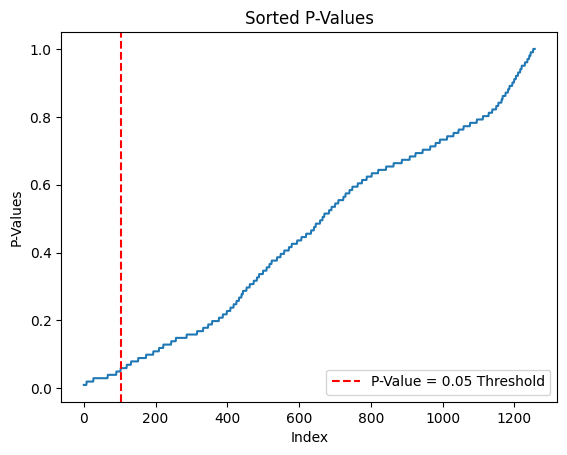

Index corresponding to p-value = 0.05: 103


In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming result_df_sorted is the DataFrame with sorted P-Values
p_value_threshold = 0.05

# Find the index corresponding to the first p-value less than or equal to 0.05
index_at_threshold = np.argmin(result_df_sorted['P-Values'] <= p_value_threshold)

# Plot the P-Values
plt.plot(result_df_sorted['P-Values'])
plt.axvline(x=index_at_threshold, color='red', linestyle='--', label=f'P-Value = {p_value_threshold} Threshold')
plt.xlabel('Index')
plt.ylabel('P-Values')
plt.title('Sorted P-Values')
plt.legend()
plt.show()

print(f'Index corresponding to p-value = {p_value_threshold}: {index_at_threshold}')


Only 103 eigenvalues convey the useful information. They can be considered a signal and not a noise.

Question 2


In [51]:
#Question 2

import numpy as np
from scipy.linalg import eigh

p=100
n=400
gamma = p/n

def simulate_pca(gamma, lambda0, sigma=1):
    u = np.eye(p)[0]

    X = np.random.multivariate_normal(np.zeros(p), sigma**2 * np.eye(p) + lambda0 * np.outer(u, u), size=n)

    # sample covariance matrix
    Sn = np.cov(X, rowvar=False)

    # eigenvalue
    eigenvalues, eigenvectors = eigh(Sn)

    idx = np.argmax(eigenvalues)
    lambda_max = eigenvalues[idx]
    v_max = eigenvectors[:, idx]

    correlation_squared = np.abs(np.dot(u, v_max))**2

    return lambda_max, correlation_squared, X, Sn


lambda0_values = np.linspace(np.sqrt(gamma) - 2, np.sqrt(gamma) + 2, 11)


results = []
for lambda0 in lambda0_values:
    lambda_max, correlation_squared, X, Sn = simulate_pca(gamma, lambda0)
    results.append((lambda_max, correlation_squared))

#
print("Lambda_max and Squared Correlation Results:")
for lambda_max, correlation_squared in results:
    print(f"Lambda_max: {lambda_max}, Squared Correlation: {correlation_squared}")

<ipython-input-51-ab4b09ba379b>:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X = np.random.multivariate_normal(np.zeros(p), sigma**2 * np.eye(p) + lambda0 * np.outer(u, u), size=n)


Lambda_max and Squared Correlation Results:
Lambda_max: 2.0437907772784474, Squared Correlation: 4.8751901542024426e-06
Lambda_max: 2.192563491777583, Squared Correlation: 0.0002960354778463027
Lambda_max: 2.2919265497106176, Squared Correlation: 5.5236129128363924e-05
Lambda_max: 2.196530734227987, Squared Correlation: 0.004227659897259152
Lambda_max: 2.093135928264208, Squared Correlation: 0.00017629710197062846
Lambda_max: 2.2121069523225865, Squared Correlation: 0.09772894233705412
Lambda_max: 2.372667763552977, Squared Correlation: 0.5319639726932597
Lambda_max: 2.6313499651431647, Squared Correlation: 0.7916041253009575
Lambda_max: 3.029137696274714, Squared Correlation: 0.7673176179375535
Lambda_max: 3.692600203373087, Squared Correlation: 0.865310313099874
Lambda_max: 3.6572795469644763, Squared Correlation: 0.8682043174103771


In [48]:
results_array = np.array(results)
lambda_max = results_array[:, 0]
print(lambda_max)

[2.20445724 2.19696609 2.15813514 2.19005372 2.20901562 2.21535518
 2.41905183 2.8571356  3.3597788  3.45539294 3.6149538 ]


In [38]:
lambda0_values

array([-1.5, -1.1, -0.7, -0.3,  0.1,  0.5,  0.9,  1.3,  1.7,  2.1,  2.5])

In [39]:
threshold = np.sqrt(gamma)
lambda_theory = [(1+np.sqrt(gamma))**2 if SNR <= np.sqrt(gamma) else (1+SNR)*(1+gamma/SNR) for SNR in lambda0_values]
lambda_theory

[2.25,
 2.25,
 2.25,
 2.25,
 2.25,
 2.25,
 2.427777777777778,
 2.742307692307693,
 3.097058823529412,
 3.469047619047619,
 3.8500000000000005]

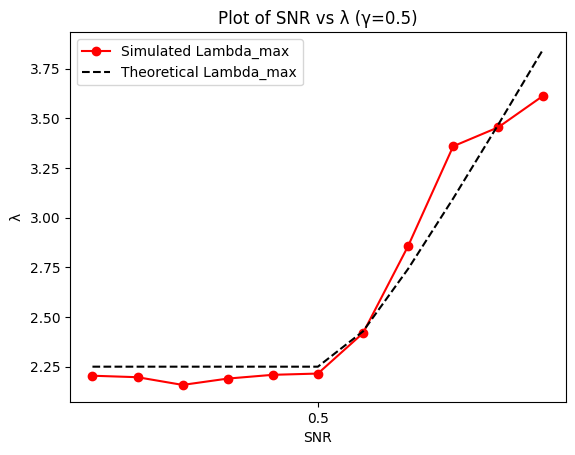

In [50]:
import matplotlib.pyplot as plt
plt.plot(lambda0_values, lambda_max, 'ro-', label='Simulated Lambda_max')
plt.plot(lambda0_values,lambda_theory, 'k--', label='Theoretical Lambda_max')
plt.xlabel('SNR')
plt.ylabel('λ')
plt.title('Plot of SNR vs λ (γ=0.5)')
plt.xticks([np.sqrt(gamma)])
plt.legend()
plt.show()


The theoretical results match the simulated results


Question 3

In [ ]:
# Question 3

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def wigner_semi_circle(t):
    return (2 / np.pi) * np.sqrt(1 - t**2)

def generate_wigner_matrix(n):
    sigma = 1 / (4 * n)
    wigner_matrix = np.random.normal(0, np.sqrt(sigma), size=(n, n))
    wigner_matrix = (wigner_matrix + wigner_matrix.T)/np.sqrt(2)   # Symmetrization
    np.fill_diagonal(wigner_matrix, 0)
    return wigner_matrix

def rank_1_perturbation_eigenvalues(n, lambda0, u):
    wigner_matrix = generate_wigner_matrix(n)
    rank_1_perturbation = wigner_matrix + lambda0 * np.outer(u, u)
    eigenvalues, _ = np.linalg.eigh(rank_1_perturbation)
    return eigenvalues


In [50]:
# Confirm Wigner's semi-circle law
n = 400
wigner_matrix = generate_wigner_matrix(n)

#W = np.zeros((n, n))

#for j in range(n):
#    for i in range(j):
#        W[i, j] = np.sqrt(1 / (4 * n)) * np.random.randn()
#        W[j, i] = W[i, j]

eigenvalues_wigner, _ = np.linalg.eigh(wigner_matrix)
#eigenvalues_wigner = np.linalg.eigvals(W)

t_values = np.linspace(-1, 1, 100)
semi_circle_values = wigner_semi_circle(t_values)



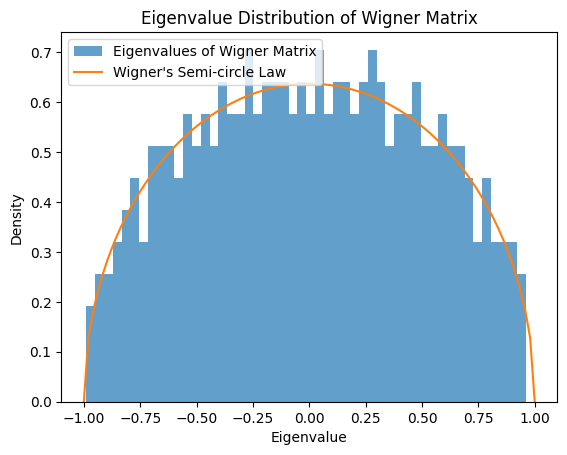

In [51]:
plt.hist(eigenvalues_wigner, bins=50, density=1, alpha=0.7, label='Eigenvalues of Wigner Matrix')
plt.plot(t_values, semi_circle_values, label="Wigner's Semi-circle Law")
plt.title("Eigenvalue Distribution of Wigner Matrix")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.legend()

plt.show()

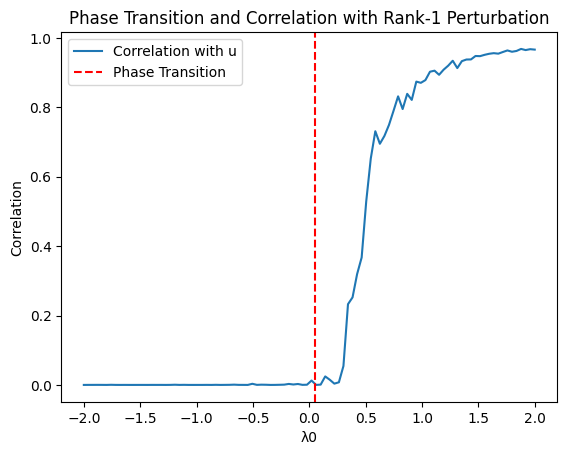

In [7]:
# Find the largest eigenvalue of a rank-1 perturbation
lambda0_values = np.linspace(-2, 2, 100)
correlations = []

for lambda0 in lambda0_values:
    u = np.random.normal(0, 1, n)
    u /= np.linalg.norm(u)

    rank_1_perturbation = wigner_matrix + lambda0 * np.outer(u, u)

    eigenvalues_perturbation = rank_1_perturbation_eigenvalues(n, lambda0, u)
    largest_eigenvalue = np.max(eigenvalues_perturbation)

    # Correlation between the top eigenvector and vector u
    top_eigenvector = np.linalg.eigh(rank_1_perturbation)[1][:, -1]
    correlation = np.abs(np.dot(u, top_eigenvector))**2

    correlations.append(correlation)

# Plot the phase transition and correlation
plt.plot(lambda0_values, correlations, label='Correlation with u')
plt.axvline(x=1 / np.sqrt(n), color='red', linestyle='--', label='Phase Transition')
plt.title("Phase Transition and Correlation with Rank-1 Perturbation")
plt.xlabel("λ0")
plt.ylabel("Correlation")
plt.legend()
plt.show()

Theoretical results match when lambda > sigma